In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import torch
import torchaudio
import numpy as np
from torchaudio import functional as F
from torchaudio.utils import download_asset
from IPython import display
import scipy.signal as ss
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import seaborn as sns
sns.set_style("whitegrid")

from src.HERB.algorithm import dereverberate
from src.LP.algorithm import LP_dereverberation
from src.WPE.wpe import wpe_dereverberation

## Sample Data

In [3]:
SAMPLE_RIR = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo-8000hz.wav")
SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")
sr = 16000

In [4]:
rir, rir_sr = torchaudio.load(SAMPLE_RIR)
rir = rir[:, int(rir_sr * 1.01) : int(rir_sr * 1.3)]
rir = rir / torch.linalg.vector_norm(rir, ord=2)
rir = torchaudio.transforms.Resample(rir_sr, sr)(rir)

display.Audio(rir, rate=sr)

In [5]:
speech, speech_sr = torchaudio.load(SAMPLE_SPEECH)
speech = torchaudio.transforms.Resample(speech_sr, sr)(speech)
display.Audio(speech, rate=sr)

In [6]:
augmented = F.fftconvolve(speech, rir)
display.Audio(augmented, rate=sr)

In [11]:
augmented = augmented.to(torch.float64).numpy().sum(axis=0)
augmented = augmented / np.abs(augmented).max()

## Applying HERB

In [27]:
#result = get_audio_hat(augmented, augmented)
result,  spectr_filter = dereverberate(augmented, steps=3, n_repeats=0)

In [13]:
result

array([-0.00372965, -0.00371926, -0.00371198, ..., -0.00034204,
       -0.00034416, -0.00034615])

In [14]:
display.Audio(result / np.abs(result).max(), rate=sr)

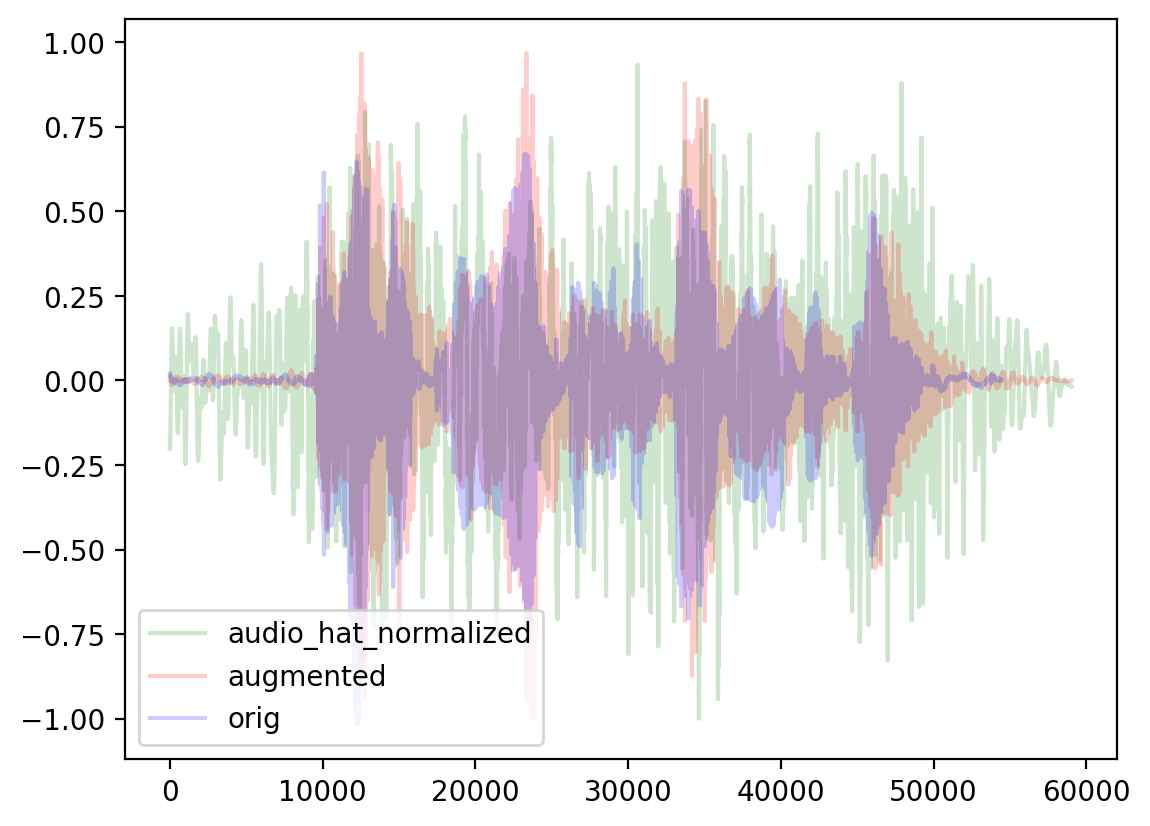

In [15]:
#plt.plot(result, color="blue", alpha=0.2, label="audio_hat")
plt.plot(result / np.abs(result).max(), color="green", alpha=0.2, label="audio_hat_normalized")
plt.plot(augmented, color="red", alpha=0.2, label="augmented")
plt.plot(speech[0].numpy(), color="blue", alpha=0.2, label="orig")
plt.legend()

##### T60

In [16]:
from pyroomacoustics.experimental.rt60 import measure_rt60

In [17]:
rir_numpy = rir[0].numpy()
rir_filtered = ss.convolve(rir_numpy, spectr_filter, mode="same")

(0.49925, 0.28974999999999995)

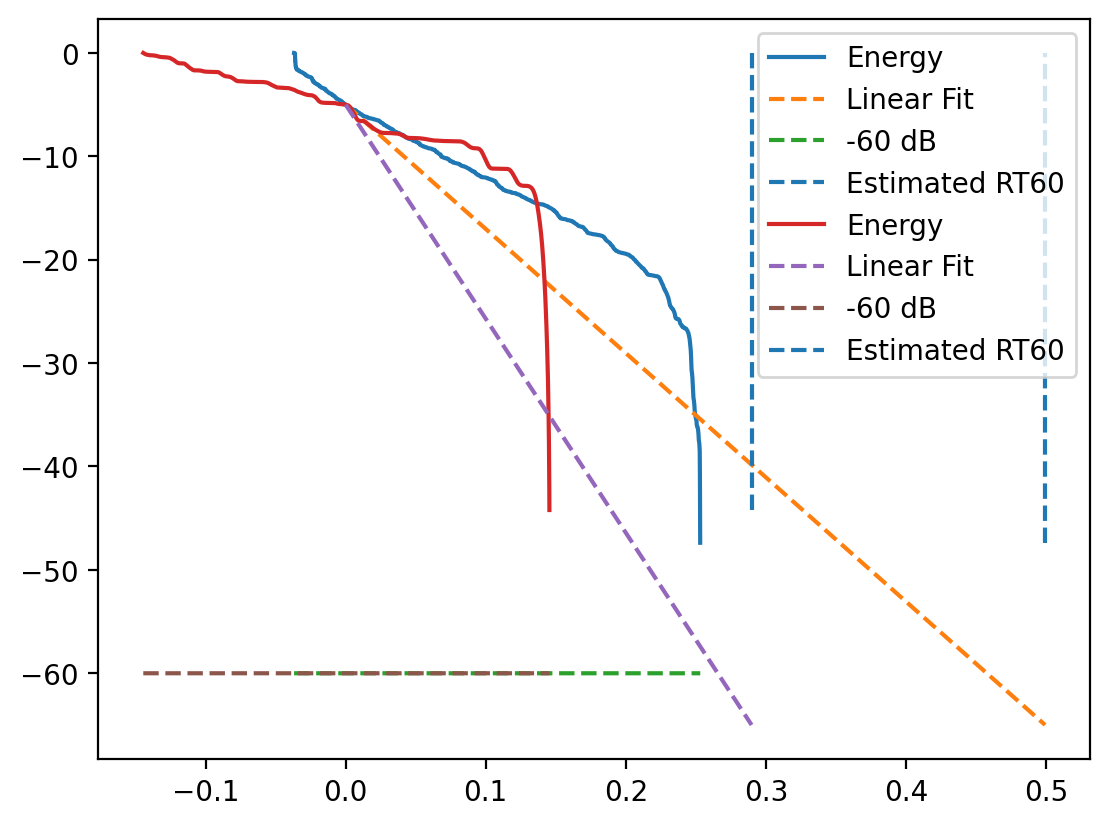

In [18]:
T60 = measure_rt60(rir_numpy, fs=16000, decay_db=30, plot=True)
filtered_T60 = measure_rt60(rir_filtered, fs=16000, decay_db=30, plot=True)

T60, filtered_T60

## Applying LP


In [19]:
Lp_derev, LP_filt = LP_dereverberation(augmented, mu = 3e-9, nIterations=500)

In [20]:
display.Audio(Lp_derev, rate=sr)    

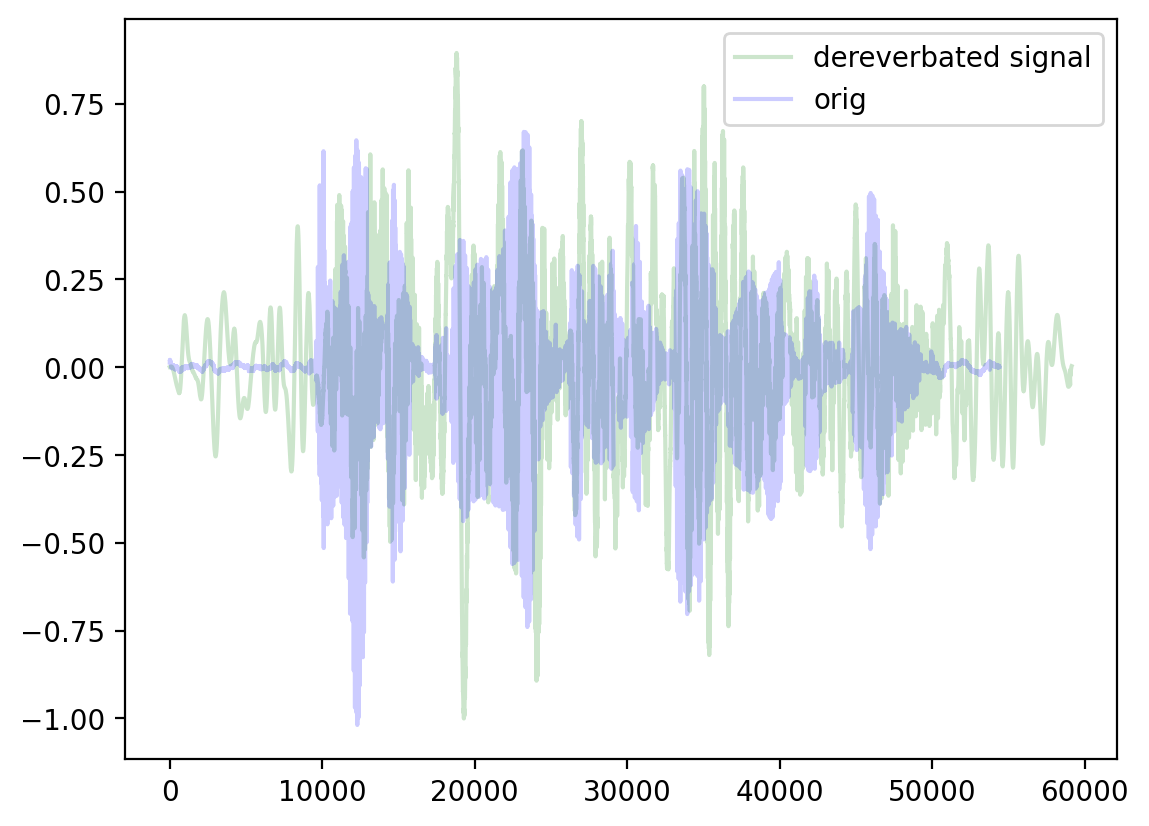

In [21]:
plt.plot(Lp_derev / np.abs(Lp_derev).max(), color="green", alpha=0.2, label="dereverbated signal")
#plt.plot(augmented, color="red", alpha=0.2, label="augmented")
plt.plot(speech[0].numpy(), color="blue", alpha=0.2, label="orig")

plt.legend()

#### T60 for LP

(0.7029375, 0.3063749999999999)

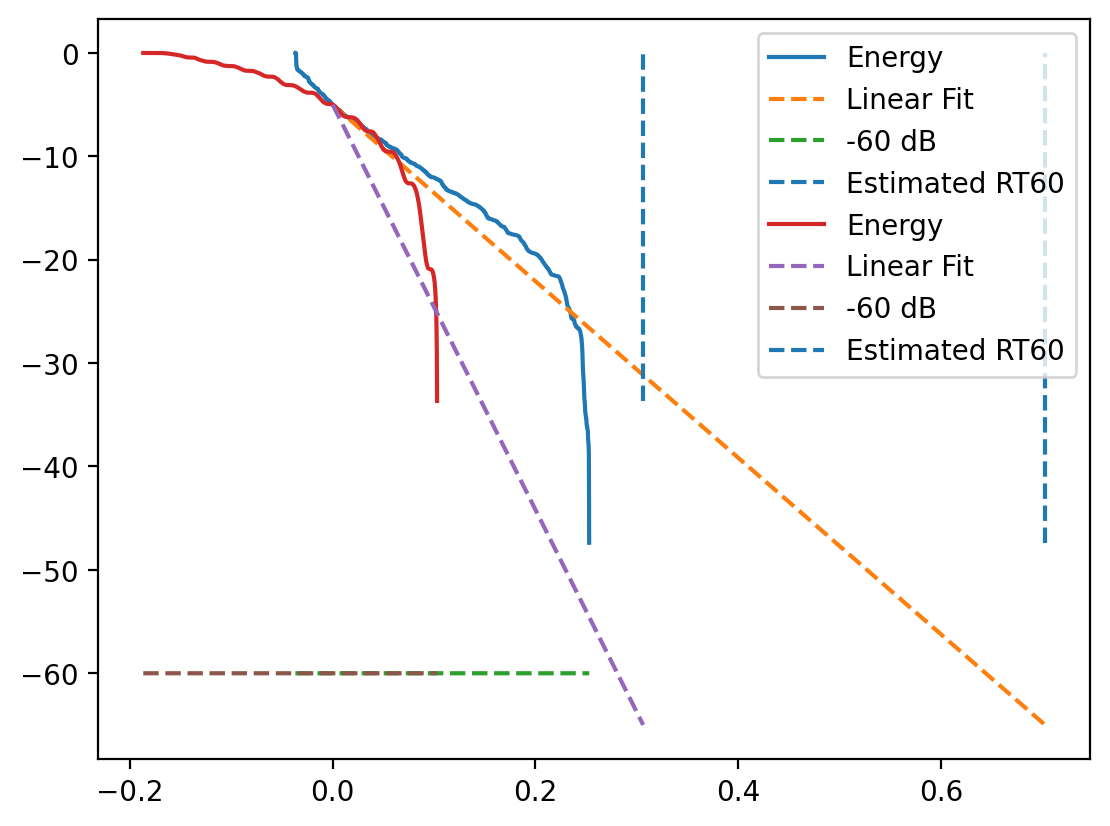

In [22]:
filtered_rir_lp = ss.lfilter(LP_filt, 1, rir_numpy)

T60 = measure_rt60(rir_numpy, fs=16000, decay_db=20, plot=True)
LP_filtered_T60 = measure_rt60(filtered_rir_lp, fs=16000, decay_db=20, plot=True)

T60, LP_filtered_T60

## Applying WPE

In [23]:
augmented.shape
# make this a 2D array
augmented_nara = augmented.reshape(1, -1)
augmented_nara.shape

(1, 59039)

In [24]:
wpe_dereverbated = wpe_dereverberation(augmented_nara)

In [25]:
display.Audio(wpe_dereverbated, rate=sr)

#### T60 for WPE

WPE does not return inverse filter, so we do not actually calculate t60 for WPE.

In [26]:
# Calculating RT60
# T60 = measure_rt60(speech, fs=16000, decay_db=20, plot=True)
# wpe_filtered_T60 = measure_rt60(wpe_dereverbated, fs=16000, decay_db=20, plot=True)
# T60, wpe_filtered_T60

# T60 plots

In [11]:
import torchaudio
import torch
import IPython
from collections import defaultdict
import random

from src.datasets import SynthesizedDataset, RealDataset
from src.utils import ROOT_PATH
from scripts.plot_t60 import get_t60_curve, RIR_COLOR, DEREVERB_COLOR


def plot_t60_on_axes(ax, data, plot_rir=True, color=None, label=None):
    rir = data["rir"]
    dereverb_rir = data["dereverb_rir"]

    if plot_rir:
        time_curve, energy_curve = get_t60_curve(rir)
        ax.plot(time_curve[time_curve >= 0], energy_curve[time_curve >= 0], color=RIR_COLOR, linewidth=2, label="RIR")

    if color is None:
        color = DEREVERB_COLOR
    if label is None:
        label = "DereverbRIR"
    
    time_curve, energy_curve = get_t60_curve(dereverb_rir)
    ax.plot(time_curve[time_curve >= 0], energy_curve[time_curve >= 0], color=color, linewidth=2, label=label)


s_dataset = SynthesizedDataset()
r_dataset = RealDataset()

data_path = ROOT_PATH / "data" / "dereverberated"

### Synthesized Dataset

In [101]:
s_info_dict = defaultdict(list)

for i, elem in enumerate(s_dataset):
    room_type = elem["speech_path"].split("/")[-1].split("_")[-1].split(".")[0]
    s_info_dict[room_type].append(f"{i:03}.pth") 

In [102]:
random.seed(11)
for k, v in s_info_dict.items():
    random.shuffle(v)

In [103]:
large_room_path = s_info_dict["largeroom1"][0]
medium_room_path = s_info_dict["mediumroom1"][0]
small_room_path = s_info_dict["smallroom1"][0]

In [104]:
def get_data(room_type, dataset_name, algorithm_name):
    elem_path = data_path / f"{dataset_name}_{algorithm_name}"
    if room_type.lower() == "large":
        elem_path = elem_path / large_room_path
    if room_type.lower() == "medium":
        elem_path = elem_path / medium_room_path
    if room_type.lower() == "small":
        elem_path = elem_path / small_room_path
    return torch.load(elem_path)

In [105]:
large_lp = get_data("large", "SynthesizedDataset", "LP")
medium_lp = get_data("medium", "SynthesizedDataset", "LP")
small_lp = get_data("small", "SynthesizedDataset", "LP")

large_herb = get_data("large", "SynthesizedDataset", "HERB")
medium_herb = get_data("medium", "SynthesizedDataset", "HERB")
small_herp = get_data("small", "SynthesizedDataset", "HERB")

large_wpe = get_data("large", "SynthesizedDataset", "WPE")
medium_wpe = get_data("medium", "SynthesizedDataset", "WPE")
small_wpe = get_data("small", "SynthesizedDataset", "WPE")

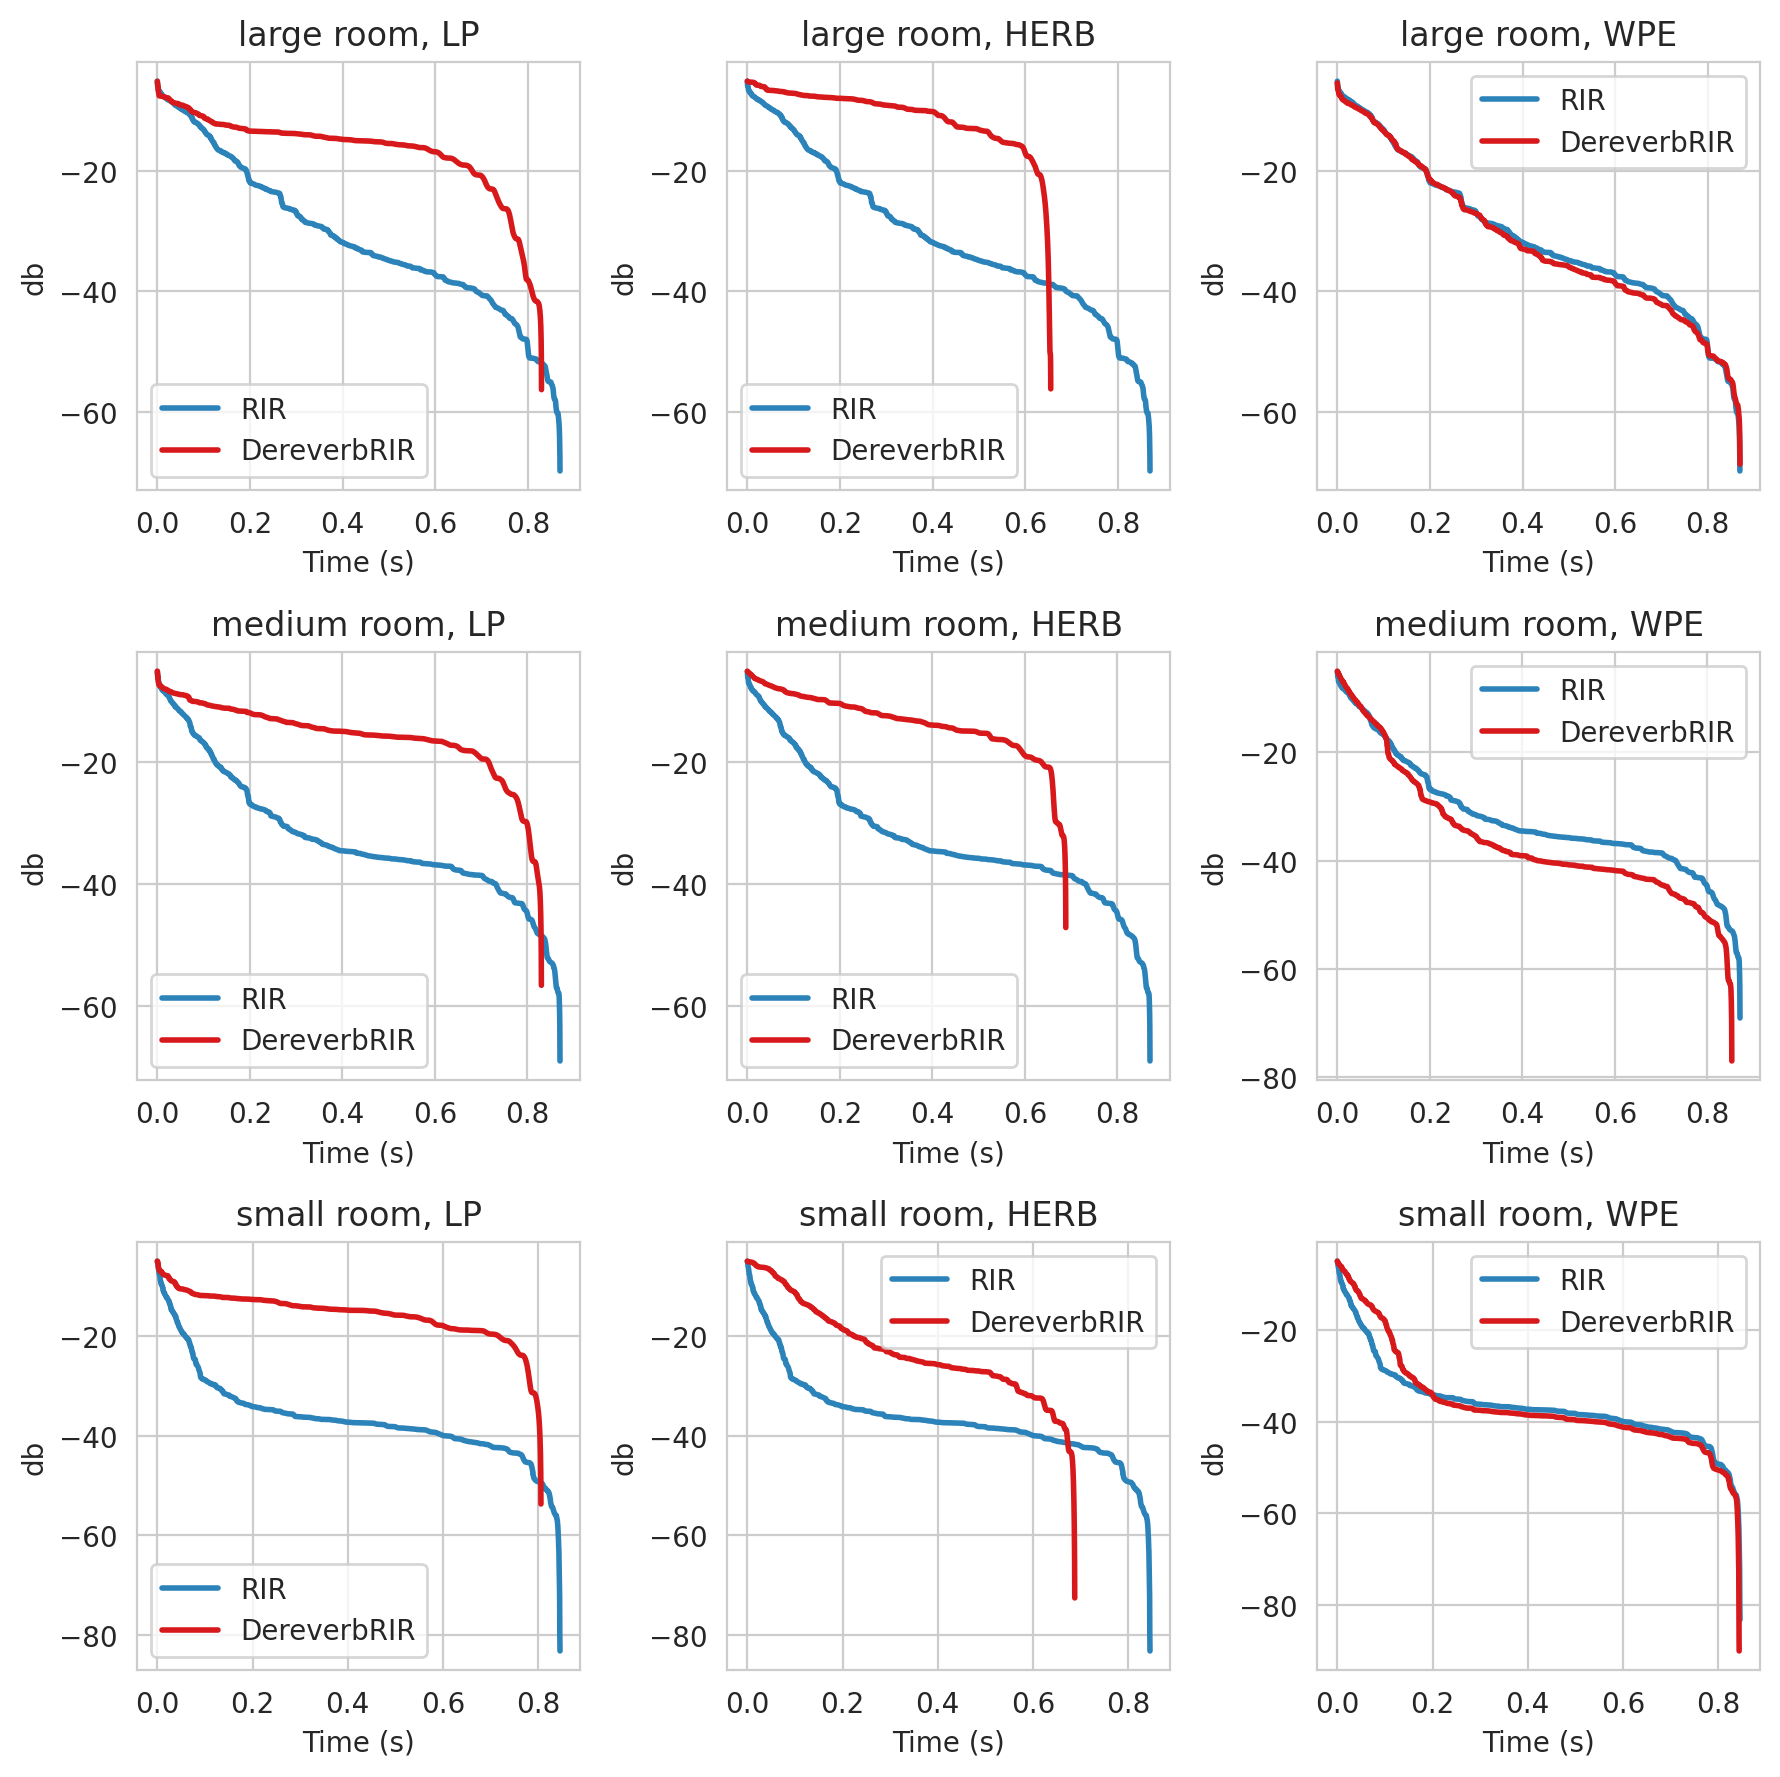

In [106]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for i, room_type in enumerate(["large", "medium", "small"]):
    for j, algorithm_name in enumerate(["LP", "HERB", "WPE"]):
        plot_t60_on_axes(axes[i][j], get_data(room_type, "SynthesizedDataset", algorithm_name))
        axes[i][j].set_title(f"{room_type} room, {algorithm_name}")
        
        axes[i][j].set_xlabel("Time (s)")
        axes[i][j].set_ylabel("db")
        axes[i][j].legend()

plt.tight_layout()

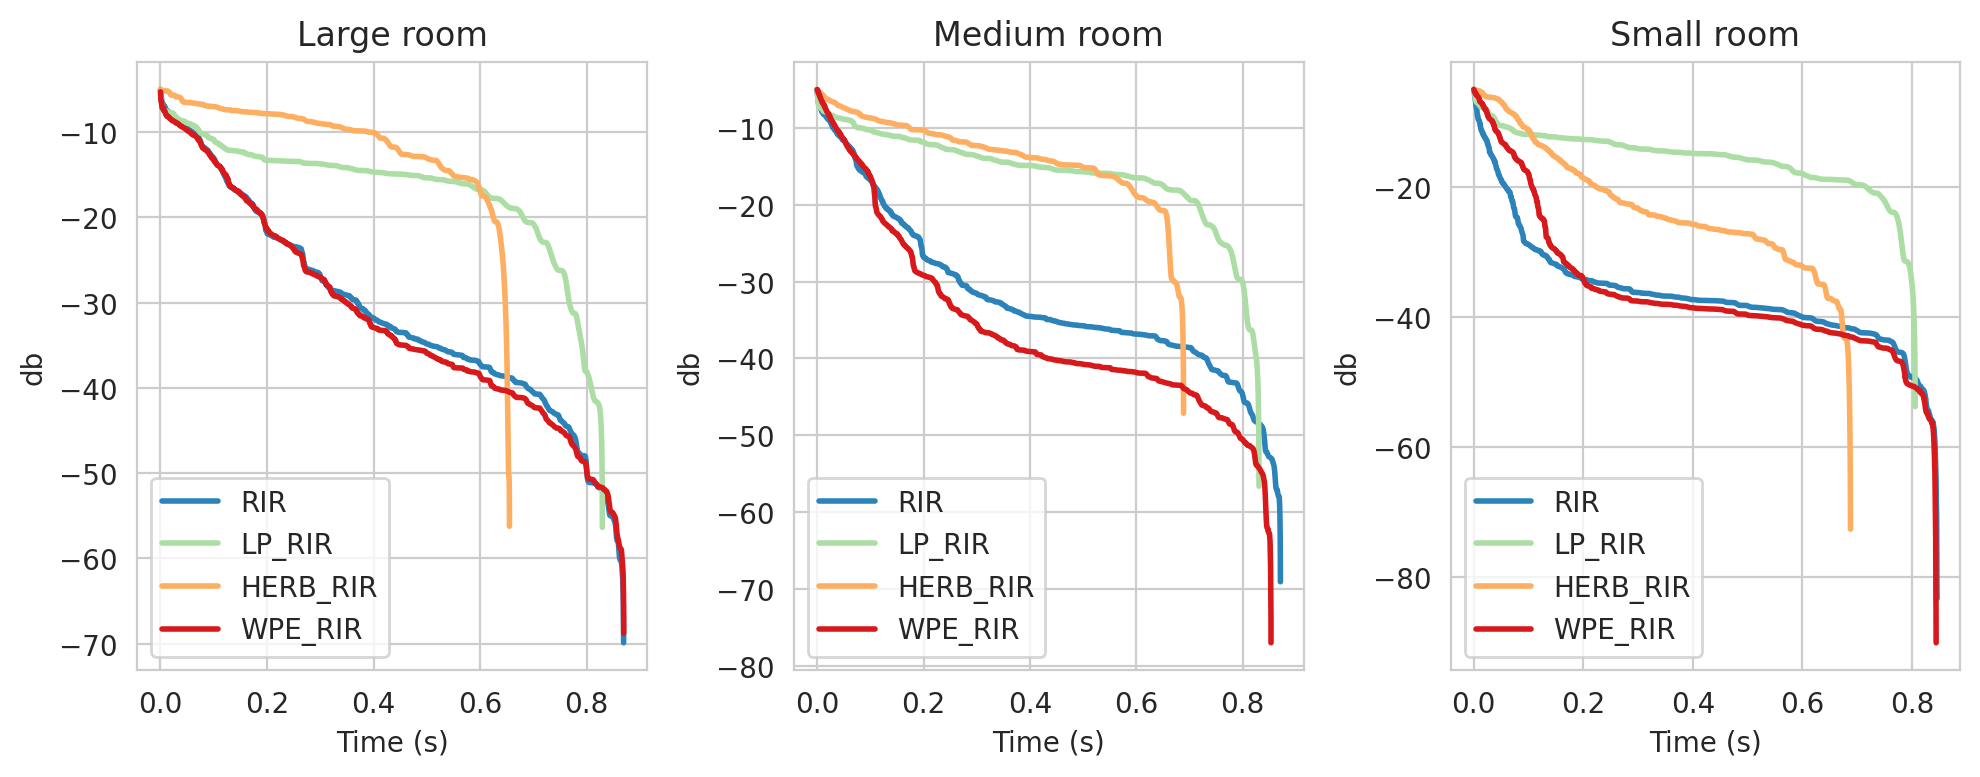

In [107]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

for i, room_type in enumerate(["Large", "Medium", "Small"]):
    for j, (algorithm_name, color) in enumerate(zip(["LP", "HERB", "WPE"], ["#abdda4", "#fdae61", "#d7191c"])):
        plot_t60_on_axes(axes[i], get_data(room_type, "SynthesizedDataset", algorithm_name),
                         plot_rir=(j==0), color=color, label=f"{algorithm_name}_RIR")
        axes[i].set_title(f"{room_type} room")
        
        axes[i].set_xlabel("Time (s)")
        axes[i].set_ylabel("db")
        axes[i].legend()

plt.tight_layout()
plt.savefig(ROOT_PATH / "data" / "plots" / "t60_synthesized_comp.pdf", dpi=600)

### Real Dataset

In [124]:
r_info_dict = defaultdict(list)

for i, elem in enumerate(r_dataset):
    room_type = elem["speech_path"].split("/")[-1].split("_")[-1].split(".")[0]
    r_info_dict[room_type].append(f"{i:03}.pth") 

In [125]:
random.seed(123)
for k, v in r_info_dict.items():
    random.shuffle(v)

In [126]:
large_room_path = r_info_dict["D105"][0] # Lecture room
medium_room_path = r_info_dict["L227"][0] # Stairs
small_room_path = r_info_dict["L207"][0] # Office

In [127]:
def get_data(room_type, dataset_name, algorithm_name):
    elem_path = data_path / f"{dataset_name}_{algorithm_name}"
    if room_type.lower() == "large":
        elem_path = elem_path / large_room_path
    if room_type.lower() == "medium":
        elem_path = elem_path / medium_room_path
    if room_type.lower() == "small":
        elem_path = elem_path / small_room_path
    return torch.load(elem_path)

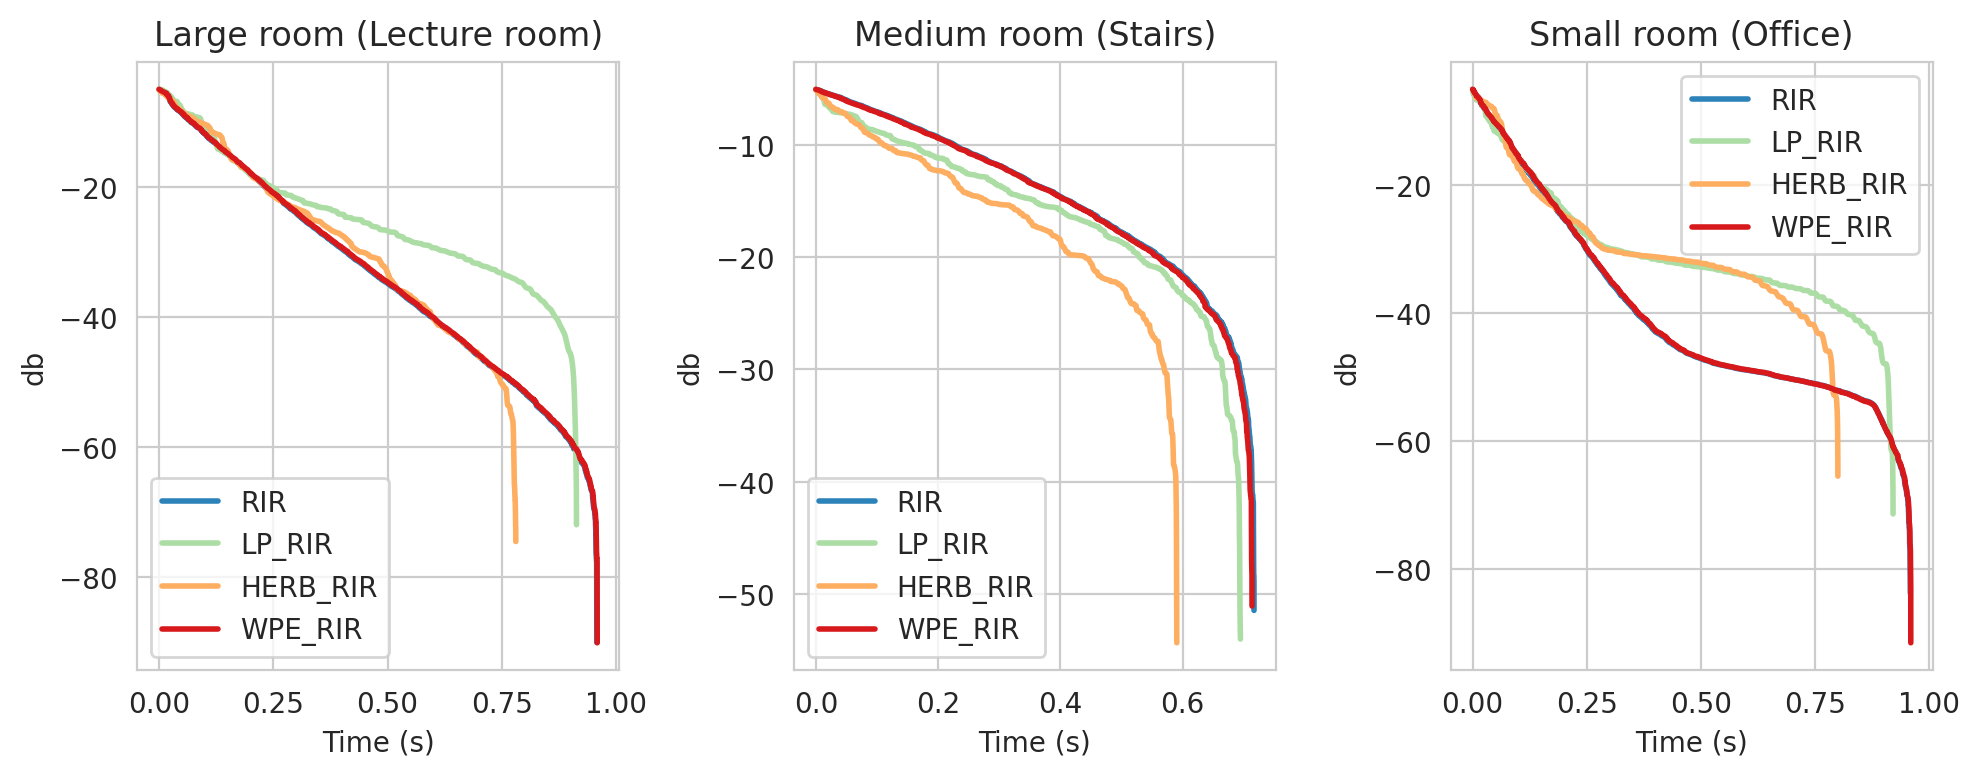

In [129]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

for i, room_type in enumerate(["Large", "Medium", "Small"]):
    for j, (algorithm_name, color) in enumerate(zip(["LP", "HERB", "WPE"], ["#abdda4", "#fdae61", "#d7191c"])):
        plot_t60_on_axes(axes[i], get_data(room_type, "RealDataset", algorithm_name),
                         plot_rir=(j==0), color=color, label=f"{algorithm_name}_RIR")

        if room_type == "Large":
            full_room = f"{room_type} room (Lecture room)"
        if room_type == "Medium":
            full_room = f"{room_type} room (Stairs)"
        if room_type == "Small":
            full_room = f"{room_type} room (Office)"
        
        axes[i].set_title(f"{full_room}")
        
        axes[i].set_xlabel("Time (s)")
        axes[i].set_ylabel("db")
        axes[i].legend()

plt.tight_layout()
plt.savefig(ROOT_PATH / "data" / "plots" / "t60_real_comp.pdf", dpi=600)